In [1]:
# 작업 환경 설정
import matplotlib.dates as md
import pandas as pd
import numpy as np
import math

import missingno as msno

import statsmodels.api as sm

from matplotlib import rc

plt.style.use('seaborn')
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
%matplotlib inline

#### 날씨 데이터 불러오기
- ASOS 관측소의 데이터만 사용
- area 184(제주), 185(고산), 188(성산), 189(서귀포)

In [3]:
weather_df = pd.read_csv("weather_v2.csv")
weather_df = weather_df[weather_df["station"] == "ASOS"]

##### datetime 컬럼을 date와 time으로 나누기

In [4]:
def split_date(data, col):
    date = data[col].str.split(' ').str[0]
    time = data[col].str.split(' ').str[1]
    return date, time

In [5]:
weather_df["date"], weather_df["time"] = split_date(weather_df, "datetime")

##### 날씨 데이터의 36개의 독립변수 중 사용할 독립변수만 추출
- 온도, 풍속, 풍향, 습도(상대) 사용

In [6]:
weather_useful = weather_df[["date", "time", "temp", "ws", "wd", "humid"]]

In [7]:
# 각 독립변수들의 Null값 확인
weather_useful.isnull().sum().sort_values()

date       0
time       0
humid     43
temp      45
ws       505
wd       610
dtype: int64

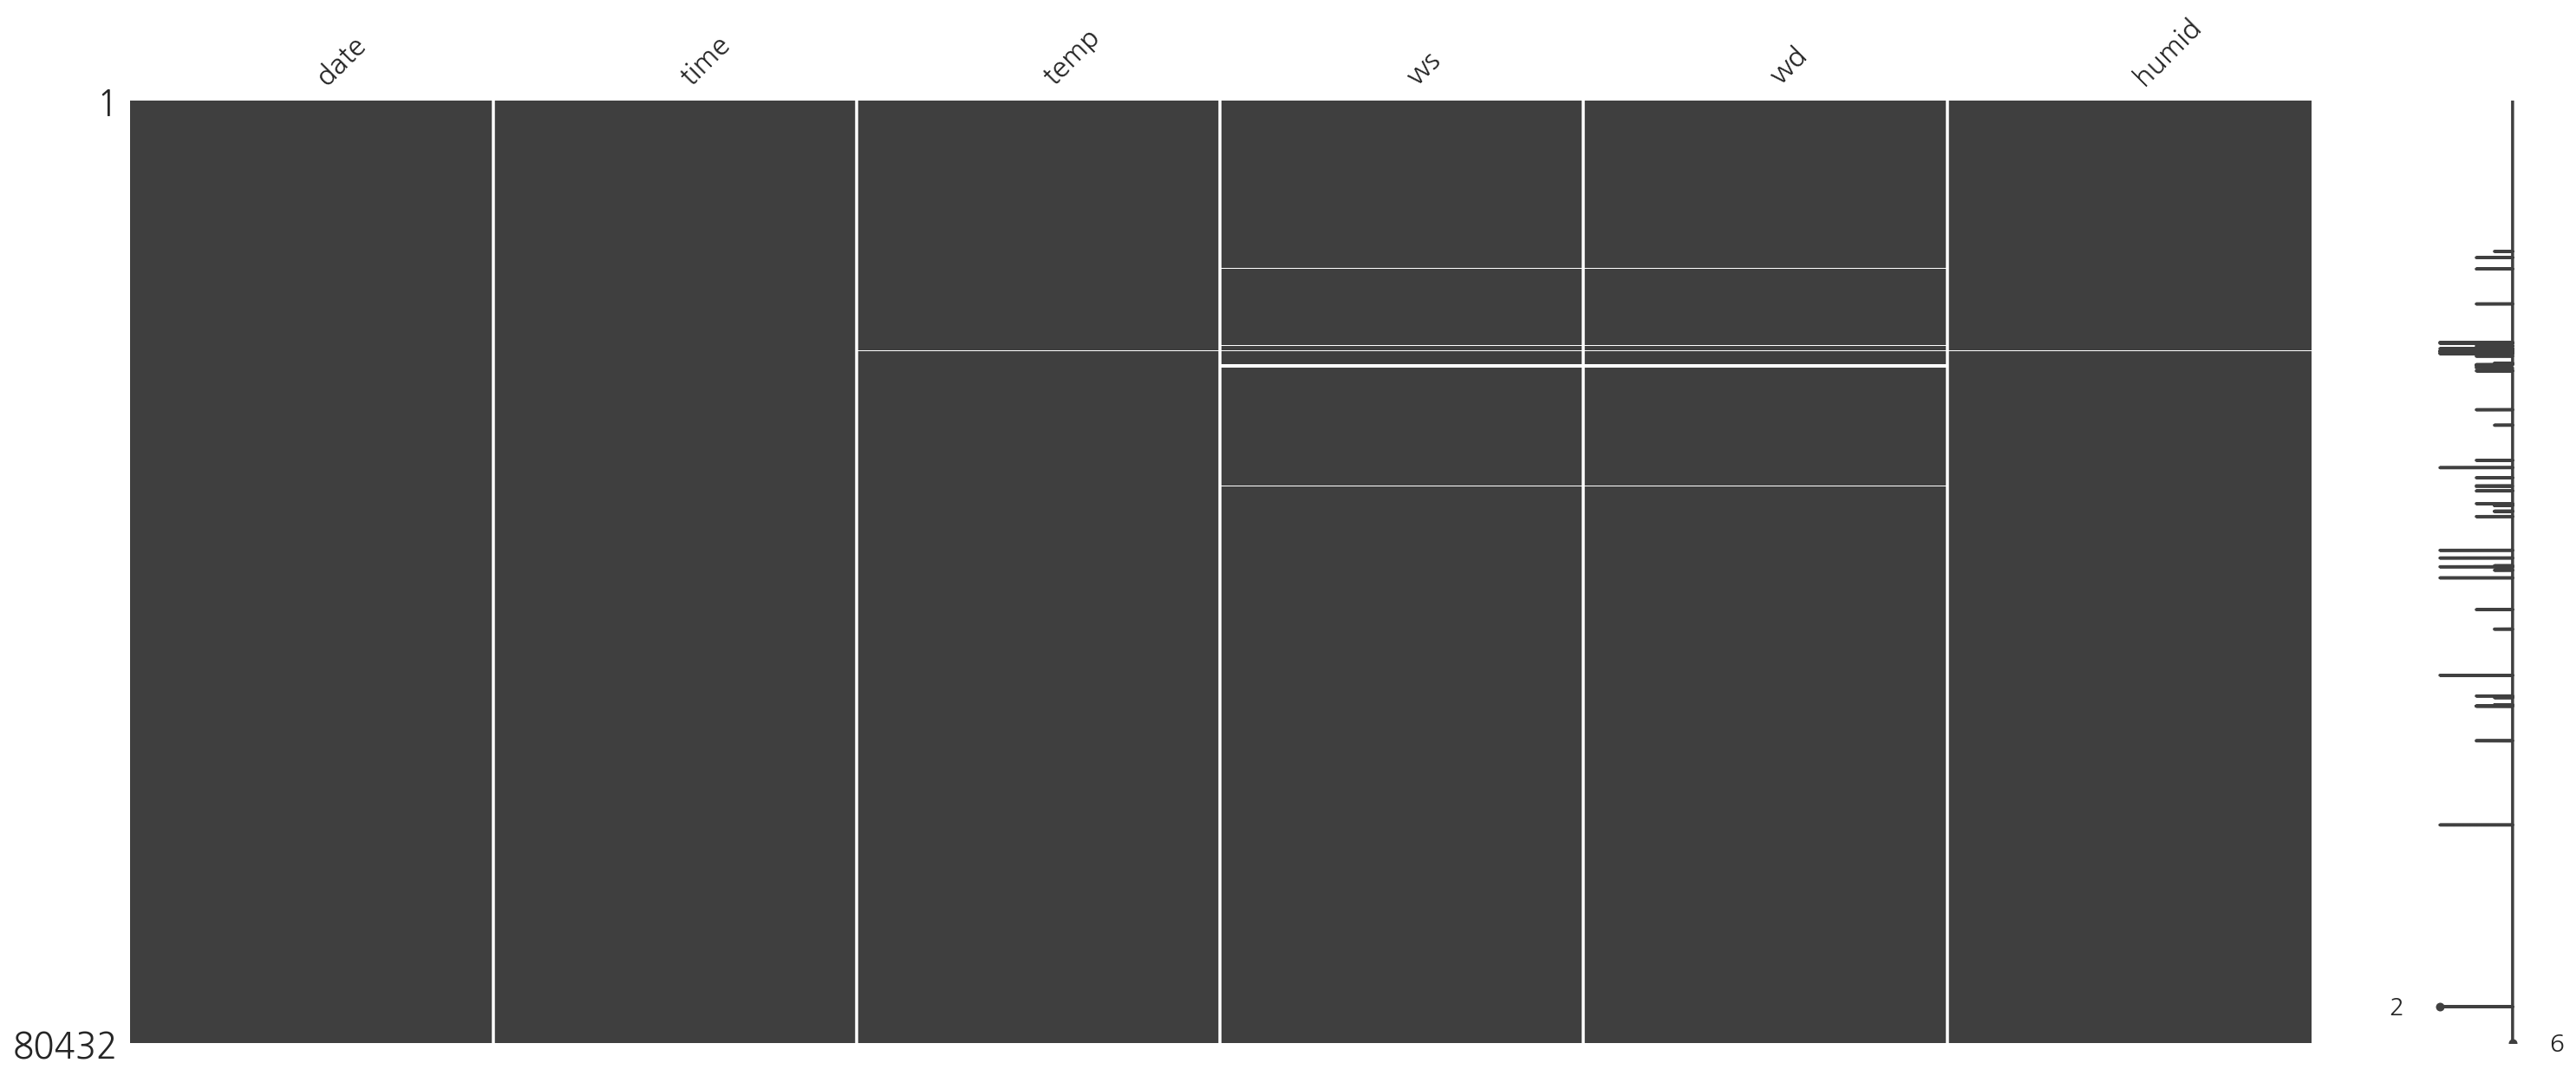

In [8]:
msno.matrix(weather_useful)
plt.show()

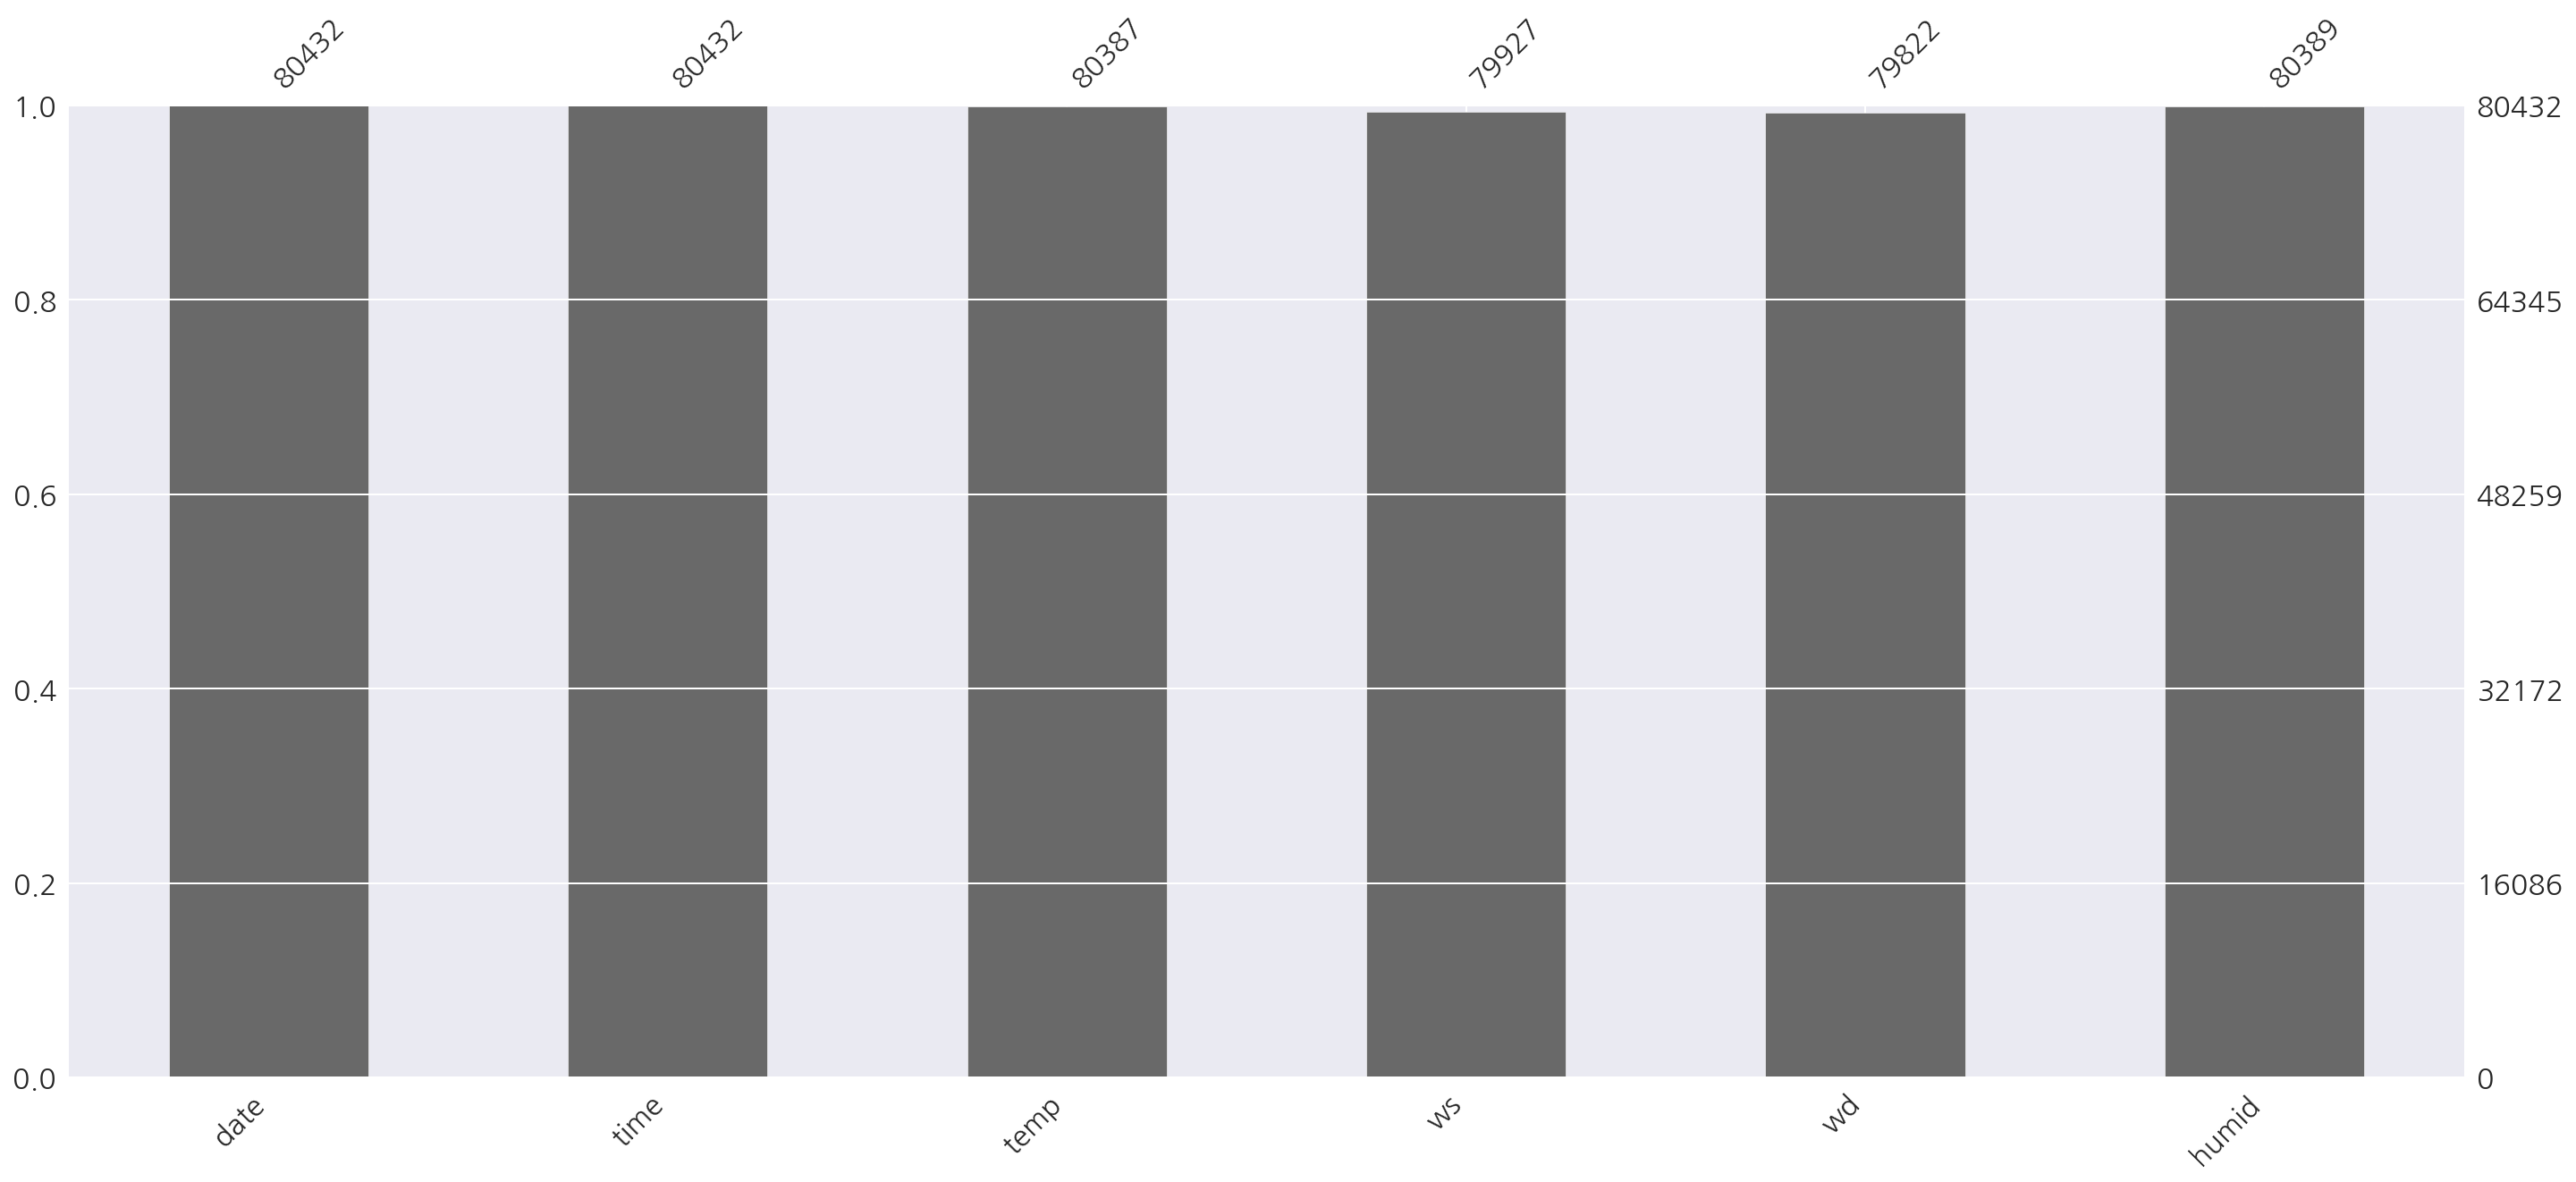

In [9]:
msno.bar(weather_useful)

##### 결측값을 채운후 결측값 확인

In [10]:
#weather_full=weather_useful.fillna(method="bfill") - 0.793 
#weather_full = weather_useful.fillna(method = "pad") #- 0.796
weather_full = weather_useful.interpolate(method='values')  #0.908

In [11]:
weather_full.isnull().sum()

date     0
time     0
temp     0
ws       0
wd       0
humid    0
dtype: int64

In [12]:
# date의 자료형을 datetime으로 변환
weather_full['date'] = pd.to_datetime(weather_full['date'])

In [13]:
weather_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80432 entries, 0 to 80431
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    80432 non-null  datetime64[ns]
 1   time    80432 non-null  object        
 2   temp    80432 non-null  float64       
 3   ws      80432 non-null  float64       
 4   wd      80432 non-null  float64       
 5   humid   80432 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 4.3+ MB


##### 체감온도 및 불쾌지수 추가
- 불쾌지수
    - 0.81 * 섭씨온도 +0.01 * 상대습도(%)（0.99*섭씨온도 - 14.3）+ 46.3
    
- 체감온도
    - 기상자료개방포털 자료 활용 (각 관측소 184(제주), 185(고산), 188(성산), 189(서귀포)에서 측정된 일간 체감온도)
        
- 자료 출처 : 체감온도 - 기상청, 불쾌지수 - 위키백과

In [14]:
# 불쾌지수 연산 함수
def discomfort_index(temp, rh):
    discomfort = round(0.81 * temp + 0.01 * rh * (0.99 * temp - 14.3) + 46.3, 1)
    return discomfort

In [15]:
# 불쾌지수 추가
weather_full["angry"] = discomfort_index(weather_full["temp"], weather_full["humid"])

In [16]:
# 시간별, 관측소별로 나눠진 데이터들을 일일 평균으로 하나의 데이터로 합침
weather_full = weather_full.groupby("date").mean().reset_index()

In [17]:
# 각 독립변수들의 값을 소수점 둘째자리에서 반올림
weather_full[["temp", "ws", "wd", "humid", "angry"]]= weather_full[["temp", "ws", "wd", "humid", "angry"]].round(1)

In [18]:
weather_full

date  temp   ws     wd  humid  angry
0   2018-02-01   4.3  3.9  201.2   60.1   43.7
1   2018-02-02   3.8  4.3  276.8   55.3   43.5
2   2018-02-03   1.3  6.9  314.9   67.3   38.6
3   2018-02-04  -1.0  7.0  314.0   72.0   34.4
4   2018-02-05  -0.1  6.5  304.7   71.2   35.9
..         ...   ...  ...    ...    ...    ...
833 2020-05-14  18.7  2.7  174.2   56.3   63.7
834 2020-05-15  19.9  3.5  208.1   91.5   67.3
835 2020-05-16  17.6  2.0  205.0   96.6   63.5
836 2020-05-17  17.1  2.2  176.8   91.6   62.4
837 2020-05-18  19.2  3.1  167.9   92.1   66.2

[838 rows x 6 columns]

In [19]:
# 체감온도 추가
body_temp = pd.read_csv("body_temp.csv")
body_temp = body_temp.drop("Unnamed: 0", axis = 1)

In [20]:
body_temp

date  temp   ws  body_temp  area
0     2018-02-01   4.7  4.0        1.9   184
1     2018-02-02   3.7  3.2        1.1   184
2     2018-02-03   1.7  6.0       -2.8   184
3     2018-02-04  -0.7  6.8       -6.1   184
4     2018-02-05   0.3  6.4       -4.7   184
...          ...   ...  ...        ...   ...
3347  2020-05-14  19.1  0.8       19.1   189
3348  2020-05-15  19.8  1.4       19.8   189
3349  2020-05-16  18.4  0.9       18.4   189
3350  2020-05-17  17.6  1.0       17.6   189
3351  2020-05-18  19.6  0.9       19.6   189

[3352 rows x 5 columns]

In [21]:
# 4개의 관측소의 평균 일별 체감온도 컬럼 추가
weather_full["body_temp"] = body_temp.groupby("date").mean().reset_index()["body_temp"].round(1)

In [22]:
weather_full

date  temp   ws     wd  humid  angry  body_temp
0   2018-02-01   4.3  3.9  201.2   60.1   43.7        1.9
1   2018-02-02   3.8  4.3  276.8   55.3   43.5        1.0
2   2018-02-03   1.3  6.9  314.9   67.3   38.6       -2.8
3   2018-02-04  -1.0  7.0  314.0   72.0   34.4       -5.8
4   2018-02-05  -0.1  6.5  304.7   71.2   35.9       -4.3
..         ...   ...  ...    ...    ...    ...        ...
833 2020-05-14  18.7  2.7  174.2   56.3   63.7       18.6
834 2020-05-15  19.9  3.5  208.1   91.5   67.3       19.8
835 2020-05-16  17.6  2.0  205.0   96.6   63.5       17.4
836 2020-05-17  17.1  2.2  176.8   91.6   62.4       17.0
837 2020-05-18  19.2  3.1  167.9   92.1   66.2       19.1

[838 rows x 7 columns]

##### 상대습도(humid)와 풍향(wd) 단위 변환
- humid : % -> /100
- wd : 디그리 -> 라디안

In [23]:
weather_full["humid"] = weather_full["humid"] / 100
weather_full["wd"] = (weather_full["wd"] * math.pi / 180).round(3)

In [24]:
weather_full

date  temp   ws     wd  humid  angry  body_temp
0   2018-02-01   4.3  3.9  3.512  0.601   43.7        1.9
1   2018-02-02   3.8  4.3  4.831  0.553   43.5        1.0
2   2018-02-03   1.3  6.9  5.496  0.673   38.6       -2.8
3   2018-02-04  -1.0  7.0  5.480  0.720   34.4       -5.8
4   2018-02-05  -0.1  6.5  5.318  0.712   35.9       -4.3
..         ...   ...  ...    ...    ...    ...        ...
833 2020-05-14  18.7  2.7  3.040  0.563   63.7       18.6
834 2020-05-15  19.9  3.5  3.632  0.915   67.3       19.8
835 2020-05-16  17.6  2.0  3.578  0.966   63.5       17.4
836 2020-05-17  17.1  2.2  3.086  0.916   62.4       17.0
837 2020-05-18  19.2  3.1  2.930  0.921   66.2       19.1

[838 rows x 7 columns]

In [25]:
weather_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       838 non-null    datetime64[ns]
 1   temp       838 non-null    float64       
 2   ws         838 non-null    float64       
 3   wd         838 non-null    float64       
 4   humid      838 non-null    float64       
 5   angry      838 non-null    float64       
 6   body_temp  838 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 46.0 KB


##### 관광객 데이터 불러오기

##### target 데이터 불러오기
- 일별 최대 smp, 최소 smp, 평균 smp, 전력 수요량

In [26]:
# target 데이터 불러오기
target = pd.read_csv("target_v2.csv")
# target의 날짜 데이터의 자료형을 str -> datetime으로 변환
target['date'] = pd.to_datetime(target['date'])

In [27]:
# target 데이터프레임의 결측값 확인
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      838 non-null    datetime64[ns]
 1   smp_max   838 non-null    float64       
 2   smp_min   838 non-null    float64       
 3   smp_mean  838 non-null    float64       
 4   supply    838 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 32.9 KB


In [28]:
# 날씨 데이터와 병합
target_v2 = target.merge(weather_full)

In [29]:
# 컬럼 재정렬
target_v2 = target_v2[["date", "smp_max", "smp_min", "smp_mean", "temp", "ws", "wd", "humid", "angry", "body_temp", "supply"]]
target_v2.head()

date  smp_max  smp_min  smp_mean  temp   ws     wd  humid  angry  \
0 2018-02-01   150.65   116.84    132.71   4.3  3.9  3.512  0.601   43.7   
1 2018-02-02   163.86   116.84    134.19   3.8  4.3  4.831  0.553   43.5   
2 2018-02-03   164.07   116.85    131.39   1.3  6.9  5.496  0.673   38.6   
3 2018-02-04   171.00   115.76    131.89  -1.0  7.0  5.480  0.720   34.4   
4 2018-02-05   170.34   123.89    137.96  -0.1  6.5  5.318  0.712   35.9   

   body_temp  supply  
0        1.9   87.47  
1        1.0   86.64  
2       -2.8   88.28  
3       -5.8   86.14  
4       -4.3   90.63

##### 각 독립변수 간의 pairplot

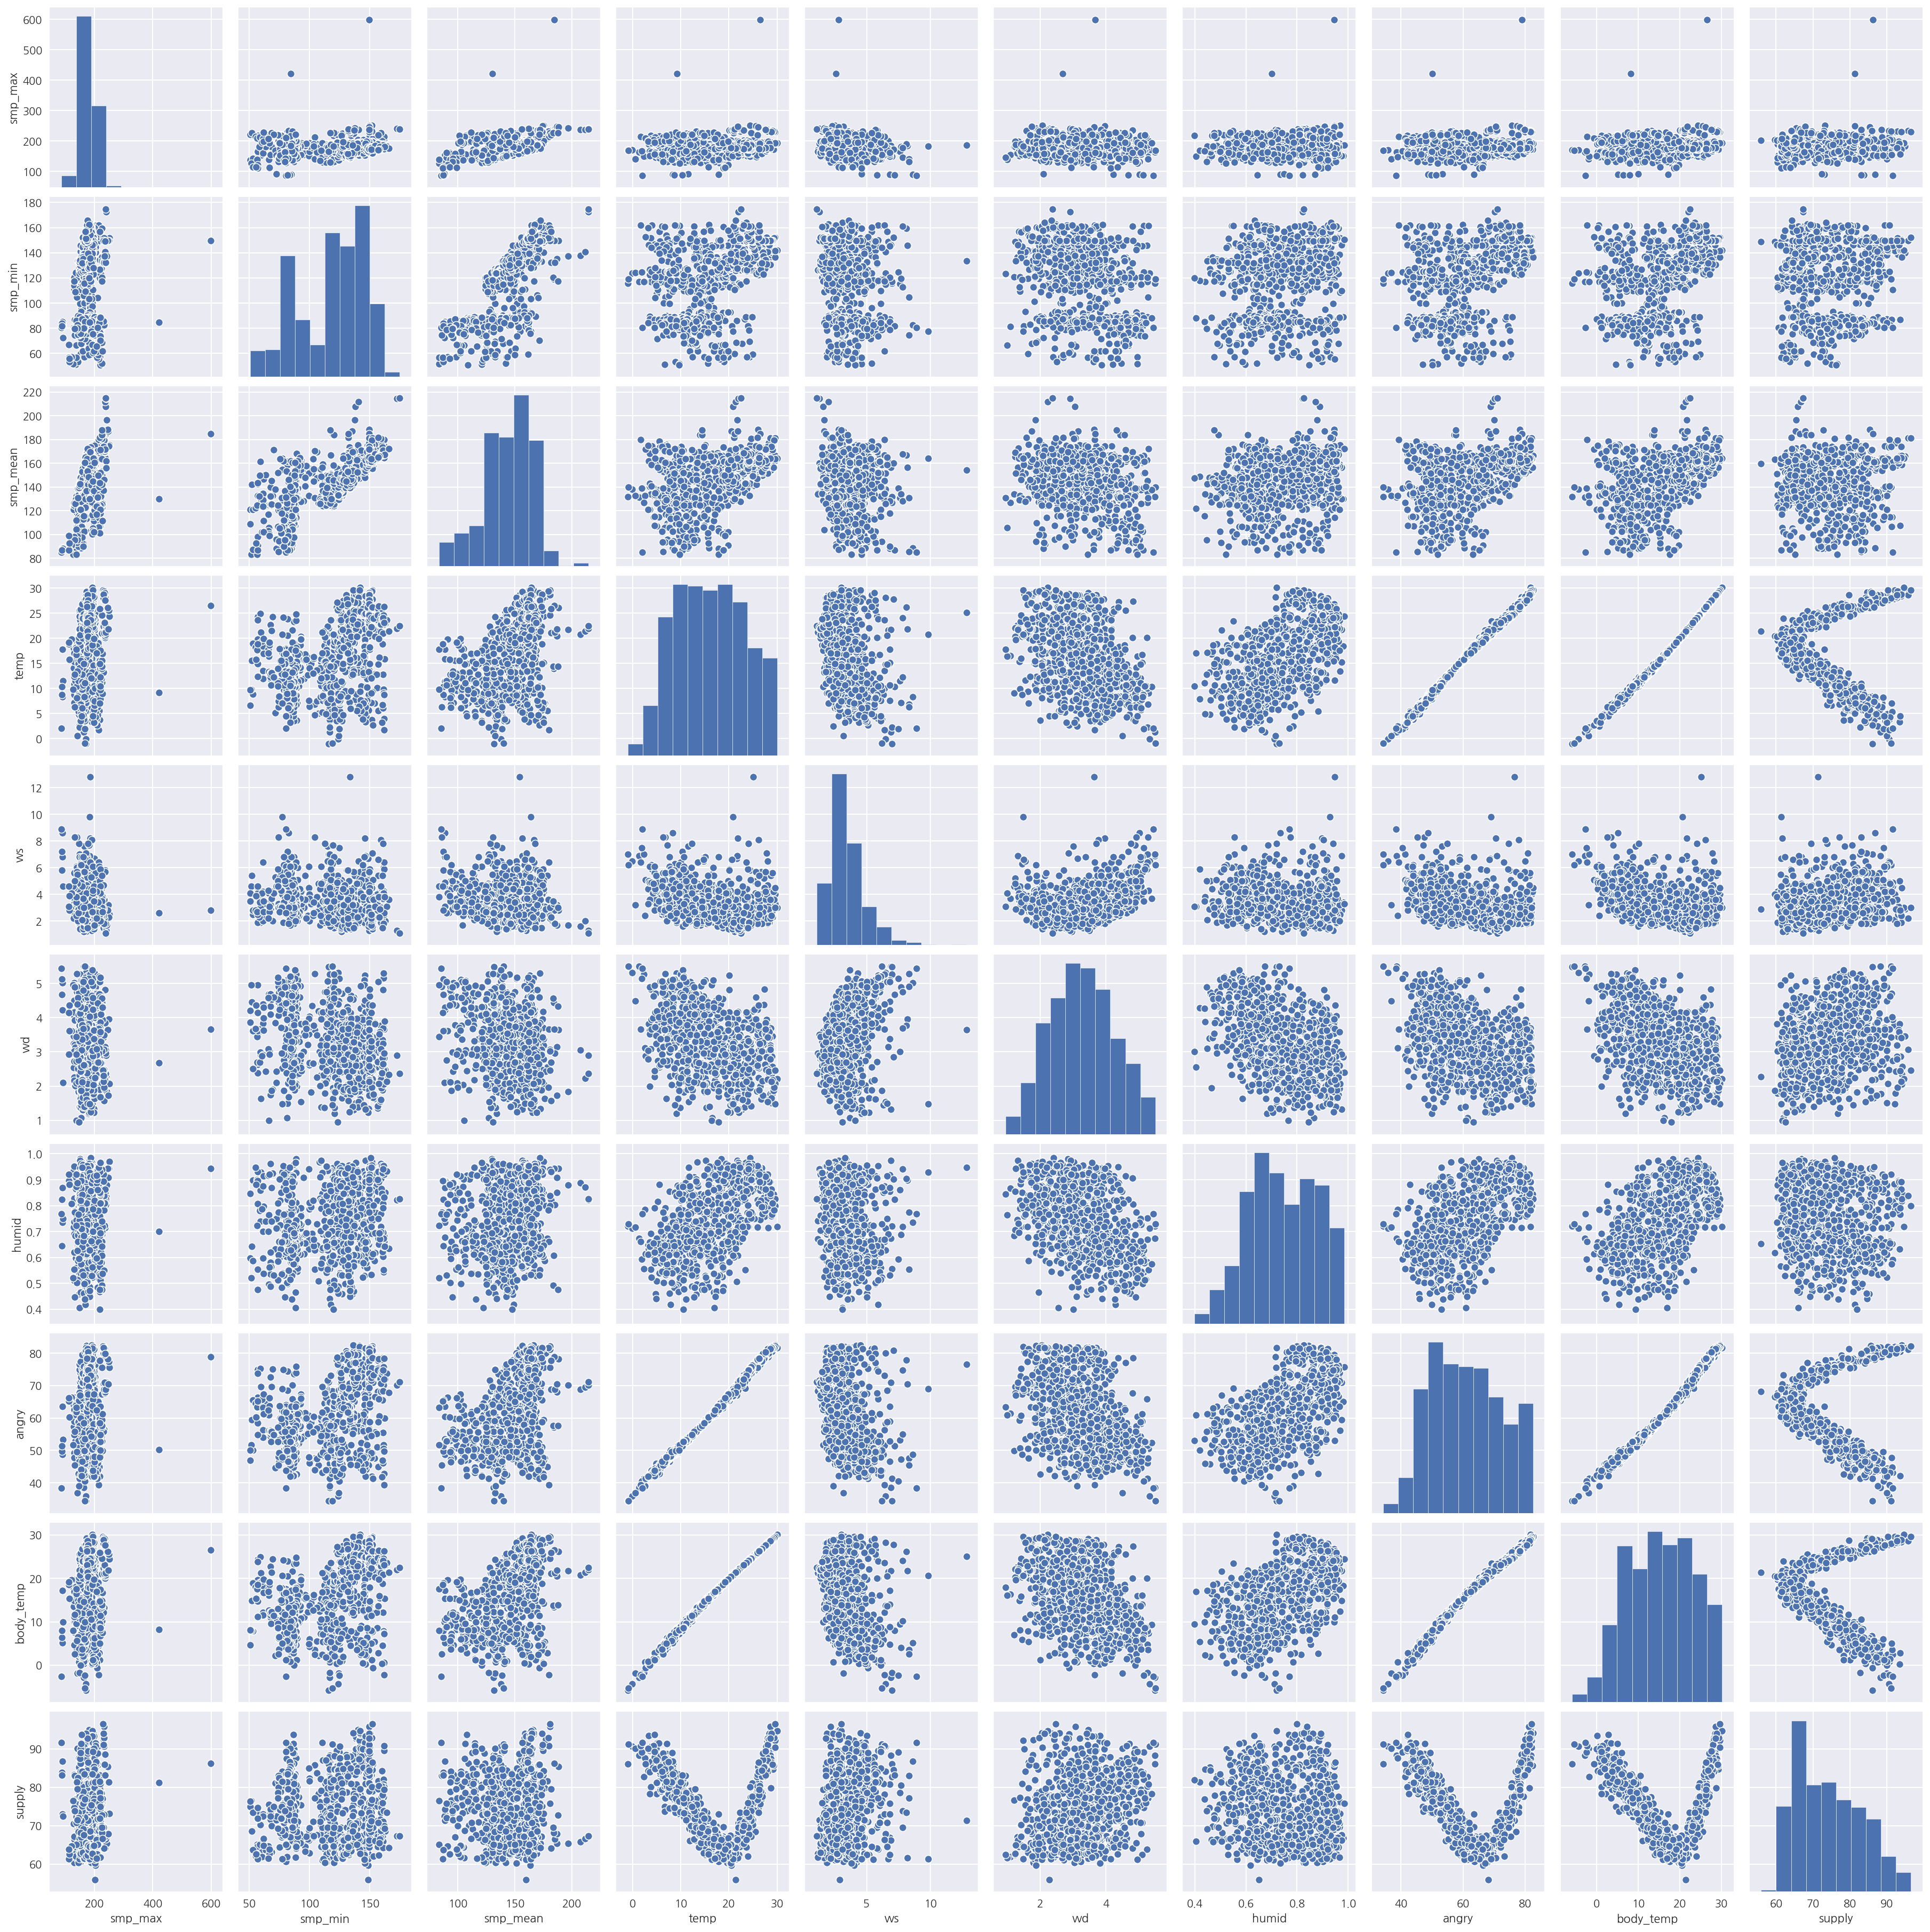

In [30]:
sns.pairplot(target_v2)
plt.show()

##### 전체 기간에 대한 각 독립변수간의 상관관계 OLS

In [32]:
formula = ("scale(supply) ~ scale(smp_max) + scale(smp_min) + scale(smp_mean) +\
                            scale(temp) + scale(ws) + scale(wd) + scale(humid) + \
                            scale(angry) + scale(body_temp)")

In [33]:
model1 = sm.OLS.from_formula(formula, data=target_v2)

In [34]:
result1 = model1.fit()

In [36]:
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:          scale(supply)   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     137.0
Date:                Wed, 17 Jun 2020   Prob (F-statistic):          2.36e-157
Time:                        11:26:10   Log-Likelihood:                -807.00
No. Observations:                 838   AIC:                             1634.
Df Residuals:                     828   BIC:                             1681.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -5.408e-15      0.022  

##### 냉방기와 난방기를 나눠서 OLS분석
- 냉방기 : 5월 ~ 10월
- 난방기 : 11월 ~ 4월

In [103]:
# 냉방기 기간 : 5월 ~10월
summer = np.logical_and((pd.DatetimeIndex(target_v2["date"]).month >= 5),\
                        (pd.DatetimeIndex(target_v2["date"]).month < 11))
# 난방기 기간 : 11월 ~ 4월
winter = np.invert(summer)

##### 냉방기 OLS

In [104]:
target_summer = target_v2[summer]

In [105]:
model_summer = sm.OLS.from_formula(formula, data=target_summer)

In [106]:
result_summer = model_summer.fit()

In [107]:
print(result_summer.summary())

                            OLS Regression Results                            
Dep. Variable:          scale(supply)   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     251.7
Date:                Wed, 17 Jun 2020   Prob (F-statistic):          3.28e-153
Time:                        11:52:03   Log-Likelihood:                -171.47
No. Observations:                 386   AIC:                             362.9
Df Residuals:                     376   BIC:                             402.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         4.987e-16      0.019  

##### 난방기 OLS

In [108]:
target_winter = target_v2[winter]

In [109]:
model_winter = sm.OLS.from_formula(formula, data=target_winter)

In [110]:
result_winter = model_winter.fit()

In [111]:
print(result_winter.summary())

                            OLS Regression Results                            
Dep. Variable:          scale(supply)   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     223.7
Date:                Wed, 17 Jun 2020   Prob (F-statistic):          1.85e-158
Time:                        11:52:04   Log-Likelihood:                -253.81
No. Observations:                 452   AIC:                             527.6
Df Residuals:                     442   BIC:                             568.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3.783e-15      0.020  

##### pca